# Data initalization

In [36]:
import pandas as pd
from pathlib import Path
import os

TRAIN_PATH = Path(os.path.abspath("")).parent / 'dataset' / 'dreaddit-train.csv'
TEST_PATH = Path(os.path.abspath("")).parent / 'dataset' / 'dreaddit-test.csv'

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# Data visualization

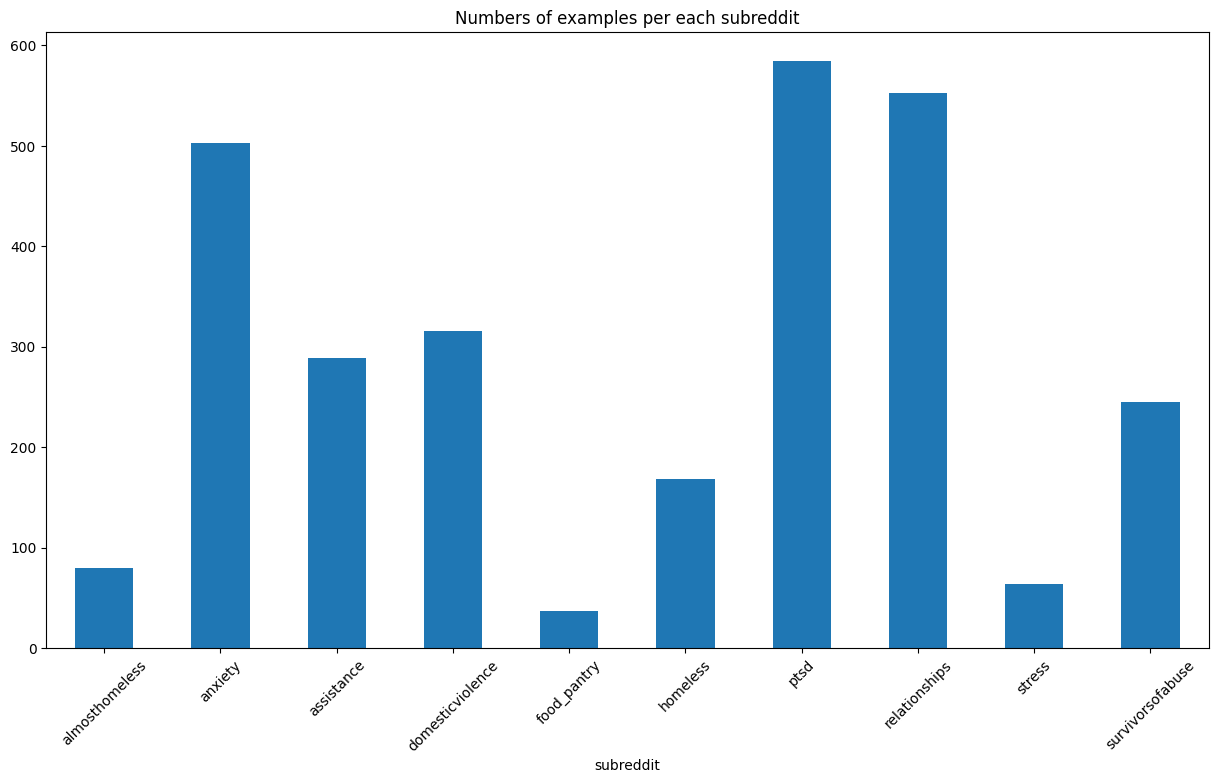

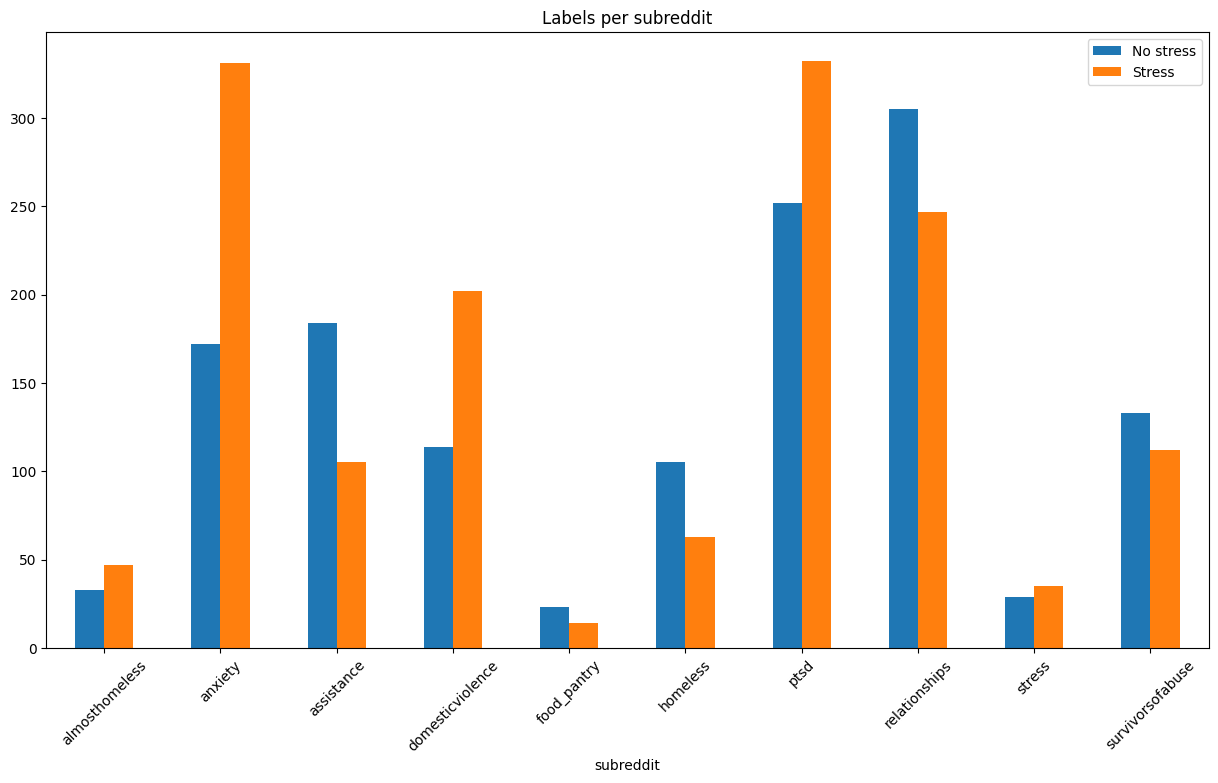

In [37]:
from matplotlib import pyplot as plt

def data_vis(train_df):
    # plt.clf()
    df=train_df.groupby(['subreddit']).size()
    # df=df.unstack()
    df.plot(kind='bar', figsize=(15,8))
    plt.xticks(rotation=45)
    plt.title("Numbers of examples per each subreddit")
    plt.show()

    # plt.clf()
    df=train_df.groupby(['subreddit',"label"]).size()
    df=df.unstack()
    df.plot(kind='bar', figsize=(15,8))
    plt.legend(["No stress", "Stress"])
    plt.xticks(rotation=45)
    plt.title("Labels per subreddit")
    plt.show()


data_vis(train)

# Spacy initalization

In [38]:
import spacy

nlp = spacy.load('en_core_web_sm')

## Preprocessing tasks
This includes:
- Tokenization
- Stop word removal
- Digit removal
- Punctuation removal

In [39]:
def tokenize(text):
    doc = nlp(text)
    tokens = []

    for tok in doc:
        if not tok.is_stop and not tok.is_digit and not tok.is_punct:
            tokens.append(tok.lemma_.lower())

    return tokens

train['processed_text'] = train['text'].apply(tokenize)
test['processed_text'] = test['text'].apply(tokenize)

In [4]:
print(train['text'][0])
print(train.shape[0])

He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.
2838


## Word2Vec vectorizer

### Initialization of the model

In [53]:
from gensim.models import Word2Vec

TRAIN_MODEL_PATH = "train-word2vec.model"

if os.path.isfile(TRAIN_MODEL_PATH):
    model_train = Word2Vec.load(TRAIN_MODEL_PATH)
else:
    model_train = Word2Vec(train['processed_text'],
        vector_size=300,
        window=5,
        min_count=2,
        workers=16)

In [60]:
model_train.save(TRAIN_MODEL_PATH)

### Averaging of the word vectors and removing out of vocabulary words

In [43]:
import numpy as np

def document_vector(doc):
    doc = [word for word in doc if word in model_train.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(300)
    return np.mean(model_train.wv[doc], axis=0)

train["doc_vector"] = train["processed_text"].apply(document_vector)
test["doc_vector"] = test["processed_text"].apply(document_vector)

# Logistic regression model

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [59]:
clf = LogisticRegression(C=300, solver="liblinear")

x = list(train["doc_vector"])
y = train["label"]

clf.fit(x, y)
y_pred = clf.predict(list(test["doc_vector"]))

acc_score = accuracy_score(test["label"], y_pred)
rec_score = recall_score(test["label"], y_pred)
prec_score = precision_score(test["label"], y_pred)
f1 = f1_score(test["label"], y_pred)
conf_matrix = confusion_matrix(test["label"], y_pred)

print(conf_matrix)

print(f"Accuracy: {acc_score}")
print(f"Recall: {rec_score}")
print(f"Precision: {prec_score}")
print(f"F1: {f1}")

[[183 163]
 [ 74 295]]
Accuracy: 0.6685314685314685
Recall: 0.7994579945799458
Precision: 0.6441048034934498
F1: 0.713422007255139


### TF-IDF weighted averaging of word embeddings

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

Concat all sentences from train and test set

In [62]:
lemmatized_sentences_train = train["processed_text"].apply(lambda x: " ".join(x))

Initalize TfidfVectorizer

In [63]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(lemmatized_sentences_train)
feature_names = tfidf.get_feature_names()
feature_name_weight = dict(zip(feature_names, tfidf.idf_))

### Add Tfidf weight to word2vec embeddings

In [64]:
def weighted_average(doc):
    doc = [word for word in doc if word in model_train.wv.key_to_index and word in feature_name_weight]
    tfidf_weights = np.array([feature_name_weight[word] for word in doc ]).reshape(-1, 1)

    if len(doc) == 0:
        return np.zeros(300)
    return np.mean(model_train.wv[doc] * tfidf_weights, axis=0)

train["doc_vector_tfidf"] = train["processed_text"].apply(weighted_average)
test["doc_vector_tfidf"] = test["processed_text"].apply(weighted_average)

AttributeError: 'ConfusionMatrixDisplay' object has no attribute 'show'

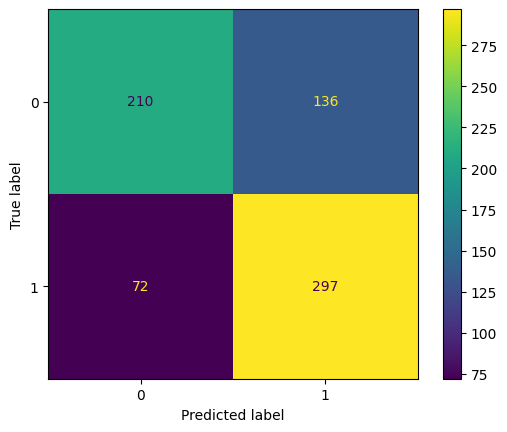

In [66]:
log_reg = LogisticRegression(C=300, solver="liblinear")

x = list(train["doc_vector_tfidf"])
y = train["label"]
log_reg.fit(x, y)

y_pred = log_reg.predict(list(test["doc_vector_tfidf"]))

## BERT classification model

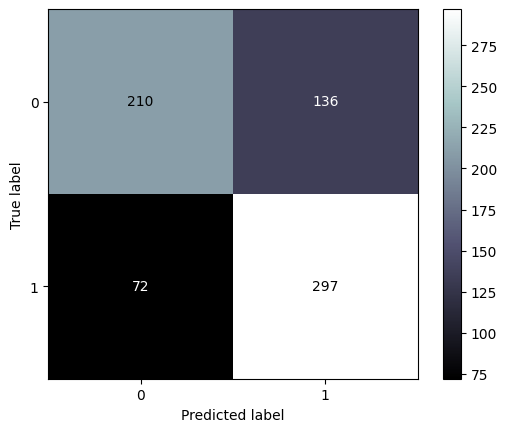

Accuracy: 0.7090909090909091
Recall: 0.8048780487804879
Precision: 0.6859122401847575
F1: 0.7406483790523691


In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rec_score = recall_score(test["label"], y_pred)
prec_score = precision_score(test["label"], y_pred)
f1 = f1_score(test["label"], y_pred)
conf_matrix = confusion_matrix(test["label"], y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])

disp.plot(cmap="bone")
plt.show()
print(f"Accuracy: {acc_score}")
print(f"Recall: {rec_score}")
print(f"Precision: {prec_score}")
print(f"F1: {f1}")


Initalize tokenizer

In [142]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/sscekic/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /home/sscekic/.cache/huggingface/transformers/0e1bbfda7f63a

Split training set into train and validation

In [5]:
train["processed_sentence"] = train["processed_text"].apply(lambda x: " ".join(x))

In [6]:
print(train["processed_sentence"][1])

hey r assistance sure right place post go =) currently student intern sandia national labs work survey help improve marketing outreach effort school recruit country look current undergrad grad stem student stem student know stem student greatly appreciate help pass short survey thank help survey enter drawing chance win $ amazon gcs


In [7]:
from sklearn.model_selection import train_test_split

train_bert, validation_bert = train_test_split(train, test_size=0.3)

In [148]:
train_bert = train_bert[["processed_sentence", "label"]]
validation_bert = validation_bert[["processed_sentence", "label"]]

Convert Pandas dataframe to Dataset

In [12]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_bert)
validation_ds = Dataset.from_pandas(validation_bert)

In [150]:
train_ds = train_ds.rename_column("processed_sentence", "text")
validation_ds = validation_ds.rename_column("processed_sentence", "text")

Convert text to tokens

In [151]:
def preprocess_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_train_ds = train_ds.map(preprocess_function, batched=True)
tokenized_validation_ds = validation_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

Map:   0%|          | 0/852 [00:00<?, ? examples/s]

In [154]:
print(tokenized_train_ds)

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1986
})


Dinamically padding sentences to the longest length in a batch

In [155]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [156]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "NOT STRESSFUL", 1: "STRESSFUL"}
label2id = {"NOT STRESSFUL": 0, "STRESSFUL": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/sscekic/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NOT STRESSFUL",
    "1": "STRESSFUL"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NOT STRESSFUL": 0,
    "STRESSFUL": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading weights file htt

Select 2 columns from pandas dataframes

In [157]:
import evaluate

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [158]:
training_args = TrainingArguments(
    output_dir="BERT_model",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_validation_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sscekic/anaconda3/envs/tarlab1/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1986
  Num Epochs 

Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 852
  Batch size = 32
Saving model checkpoint to BERT_model/checkpoint-63
Configuration saved in BERT_model/checkpoint-63/config.json
Model weights saved in BERT_model/checkpoint-63/pytorch_model.bin
tokenizer config file saved in BERT_model/checkpoint-63/tokenizer_config.json
Special tokens file saved in BERT_model/checkpoint-63/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely i

TrainOutput(global_step=315, training_loss=0.43155377100384423, metrics={'train_runtime': 653.7687, 'train_samples_per_second': 15.189, 'train_steps_per_second': 0.482, 'total_flos': 192088077066720.0, 'train_loss': 0.43155377100384423, 'epoch': 5.0})

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("BERT_model/checkpoint-315")
model = AutoModelForSequenceClassification.from_pretrained("BERT_model/checkpoint-315")

In [21]:
test["processed_sentence"] = test["processed_text"].apply(lambda x: " ".join(x))
test_bert = test[["processed_sentence", "label"]]
test_ds = Dataset.from_pandas(test_bert)
test_ds = test_ds.rename_column("processed_sentence", "text")

In [22]:
inputs = tokenizer(test_ds["text"], truncation=True, padding=True, return_tensors="pt")

In [30]:
import torch

with torch.no_grad():
    logits = model(**inputs).logits
    predicted_class_id = logits.argmax(dim=1)


In [31]:
y_pred = predicted_class_id.tolist()

acc_score = accuracy_score(test["label"], y_pred)
rec_score = recall_score(test["label"], y_pred)
prec_score = precision_score(test["label"], y_pred)
f1 = f1_score(test["label"], y_pred)
conf_matrix = confusion_matrix(test["label"], y_pred)

print(conf_matrix)
print(f"Accuracy: {acc_score}")
print(f"Recall: {rec_score}")
print(f"Precision: {prec_score}")
print(f"F1: {f1}")

[[227 119]
 [ 77 292]]
Accuracy: 0.7258741258741259
Recall: 0.7913279132791328
Precision: 0.7104622871046229
F1: 0.7487179487179487


### ChatGPT 3.5 predictions

In [33]:
GPT_PATH = Path(os.path.abspath("")).parent / 'dataset' / 'chatGPT-output.csv'

gpt = pd.read_csv(GPT_PATH)

[[190 156]
 [ 21 348]]
Accuracy: 0.7524475524475525
Recall: 0.943089430894309
Precision: 0.6904761904761905
F1: 0.7972508591065293


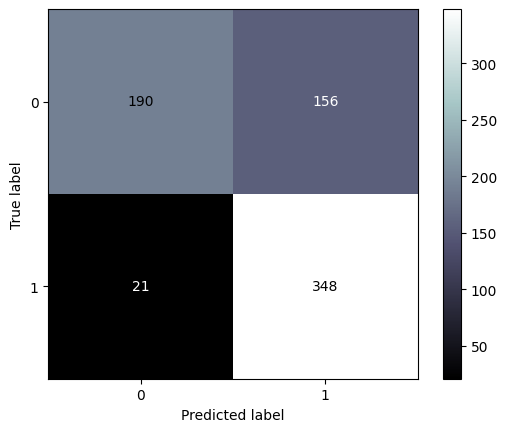

In [74]:
y_pred = gpt["Label"]

acc_score = accuracy_score(test["label"], y_pred)
rec_score = recall_score(test["label"], y_pred)
prec_score = precision_score(test["label"], y_pred)
f1 = f1_score(test["label"], y_pred)
conf_matrix = confusion_matrix(test["label"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])

disp.plot(cmap="bone")

print(conf_matrix)
print(f"Accuracy: {acc_score}")
print(f"Recall: {rec_score}")
print(f"Precision: {prec_score}")
print(f"F1: {f1}")